# EXP07: Table-aware RAG
**목표**: 테이블 저장/검색/추출 파이프라인 재설계로 table 질문 성능 격차 해소

### EXP06 핵심 교훈
- table KW_v2 = 0.566 vs text KW_v2 = 0.780 (격차 21.4%p) — **테이블 파싱 품질이 근본 병목**
- 정규화/컷 전략/프롬프트 개선은 text 질문에만 유효, table 질문은 구조 손실(structural information loss)이 원인
- 마크다운 파이프 변환 시 헤더-셀 관계, 병합 셀, 계층, caption/주석 정보 손실

### 실험 구조
| Phase | 내용 | 목적 |
|-------|------|------|
| Phase 0 | 테이블 파싱 품질 진단 | 현행 마크다운 변환의 구조 손실 정량화 |
| Phase 1 | JSON 스키마 재파싱 | table-level + row/cell-level 2레벨 문서 구축 |
| Phase 2 | Table-aware 2단 검색 | table 후보 선정 → row/cell 정밀 검색 비교 |
| Phase 3 | 통합 검증 (3-run) | 최종 성능 + RAGAS + EXP06 대비 비교 |

### 목표 지표 (3-run 평균 기준)
| Metric | EXP06 | EXP07 목표 |
|--------|-------|----------|
| KW_Acc (v2) | 0.724 | >= 0.80 |
| table KW_v2 | 0.566 | >= 0.70 |
| Faithfulness | 0.894 | >= 0.90 |
| CR | 0.850 | >= 0.90 |

### 핵심 KPI
| KPI | 정의 | 목적 |
|-----|------|------|
| Table Oracle | 정답 table_id가 table-level top-K에 포함되는가 | 테이블 후보 선정 품질 |
| Cell Hit@K | 정답 value가 row/cell top-N에 포함되는가 | 셀 검색 정밀도 |
| table-text gap | table KW_v2 - text KW_v2 격차 변화 | 구조 손실 해소 정도 |

In [11]:
# ============================================================
# 1. Setup
# ============================================================
import os
import re
import gc
import json
import time
import shutil
import hashlib
import warnings
from datetime import datetime
from collections import defaultdict

from dotenv import load_dotenv
load_dotenv()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pdfplumber
import torch

from datasets import Dataset
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_chroma import Chroma
from langchain_community.retrievers import BM25Retriever

from ragas import evaluate
from ragas.metrics import Faithfulness, ContextRecall
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper

from sentence_transformers import CrossEncoder

from bidflow.parsing.preprocessor import TextPreprocessor
from bidflow.eval.ragas_runner import FixedTempChatOpenAI

warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
if DEVICE == 'cuda':
    gpu_name = torch.cuda.get_device_name(0)
    gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1024**3
    print(f'[GPU] {gpu_name} ({gpu_mem:.1f} GB VRAM)')
else:
    print('[CPU] GPU not available')
print(f'[Device] {DEVICE}')
print('[OK] Setup complete')

[GPU] NVIDIA GeForce RTX 4080 SUPER (16.0 GB VRAM)
[Device] cuda
[OK] Setup complete


In [12]:
# ============================================================
# 2. Config & Data Load
# ============================================================
EXP04_REPORT_PATH = '../data/experiments/exp04_report.json'
EXP06_FORENSIC_PATH = '../data/experiments/exp06_forensic.json'
EXP06_REPORT_PATH = '../data/experiments/exp06_report.json'
GOLDEN_TESTSET_PATH = '../data/experiments/golden_testset.csv'
CHROMA_BASE_PATH = '../data/chroma_exp/exp07'

OUT_FORENSIC_PATH = '../data/experiments/exp07_forensic.json'
OUT_REPORT_PATH = '../data/experiments/exp07_report.json'
OUT_CSV_PATH = '../data/experiments/exp07_results.csv'
OUT_FIG_PATH = '../data/experiments/exp07_results.png'
INTERMEDIATE_PATH = '../data/experiments/exp07_intermediate.json'

EMBED_MODEL = 'text-embedding-3-small'
GEN_MODEL = 'gpt-5-mini'
RERANKER_MODEL = 'BAAI/bge-reranker-v2-m3'

ALPHA = 0.7
RERANK_POOL = 50
TOP_K = 15
N_RUNS = 3

print('=' * 60)
print('EXP07: Table-aware RAG')
print('=' * 60)

with open(EXP04_REPORT_PATH, 'r', encoding='utf-8') as f:
    exp04 = json.load(f)
FACT_SHEET_DATA = exp04['meta']['fact_sheet']
SAMPLE_FILE = exp04['meta']['sample_file']
fact_lines = [f'- {k}: {v}' for k, v in FACT_SHEET_DATA.items() if v and v != '확인불가']
FACT_SHEET = '\n'.join(fact_lines)

with open(EXP06_FORENSIC_PATH, 'r', encoding='utf-8') as f:
    exp06_forensic = json.load(f)

golden_df = pd.read_csv(GOLDEN_TESTSET_PATH)
golden_df = golden_df[golden_df['question'].notna() & (golden_df['question'] != '')]
golden_df = golden_df[~golden_df['ground_truth'].str.contains(r'\[여기에', na=False)]
golden_df = golden_df.reset_index(drop=True)

print(f'  Baseline: EXP06 (KW_v2=0.724, Faith=0.894, CR=0.850)')
print(f'  Test cases: {len(golden_df)}')
print(f'  Multi-run: N={N_RUNS}')
print(f'  Fixed: reranker@{RERANK_POOL}, alpha={ALPHA}')

EXP07: Table-aware RAG
  Baseline: EXP06 (KW_v2=0.724, Faith=0.894, CR=0.850)
  Test cases: 30
  Multi-run: N=3
  Fixed: reranker@50, alpha=0.7


In [13]:
# ============================================================
# 3. Helper Functions
# ============================================================

def robust_rmtree(path):
    if not os.path.exists(path): return
    for _ in range(5):
        try: shutil.rmtree(path); return
        except PermissionError: gc.collect(); time.sleep(1)
        except Exception: return


# ──────────────────────────────────────────────────────
# 정규화 v2 (EXP06에서 검증 완료)
# ──────────────────────────────────────────────────────
SYNONYM_MAP = {
    '통합로그인': 'sso', '단일 로그인': 'sso', '싱글사인온': 'sso',
    '간편인증': '간편인증', '간편 인증': '간편인증',
    '2차인증': '2차인증', '2차 인증': '2차인증', '추가인증': '2차인증',
    'project manager': 'pm', '사업관리자': 'pm', '사업책임자': 'pm', '프로젝트 매니저': 'pm',
    'project leader': 'pl', '프로젝트 리더': 'pl',
    'quality assurance': 'qa', '품질관리': 'qa', '품질보증': 'qa',
    '하자보수': '하자보수', '하자 보수': '하자보수',
    '발주처': '발주기관', '발주 기관': '발주기관',
}

def normalize_answer_v2(text):
    if not isinstance(text, str): return str(text).strip().lower()
    t = text.strip().lower()
    t = re.sub(r'[\u00b7\u2027\u2022\u2219]', ' ', t)
    t = re.sub(r'[\u201c\u201d\u2018\u2019\u300c\u300d\u300e\u300f]', '', t)
    t = re.sub(r'[-\u2013\u2014]', ' ', t)
    t = re.sub(r'(\d),(?=\d{3})', r'\1', t)
    t = re.sub(r'(\d+)\s*(%|퍼센트|percent)', r'\1%', t)
    t = re.sub(r'(\d+)\s*원', r'\1원', t)
    t = re.sub(r'(\d+)\s*억\s*원', r'\1억원', t)
    t = re.sub(r'(\d+)\s*만\s*원', r'\1만원', t)
    t = t.replace('v.a.t', 'vat').replace('vat 포함', 'vat포함')
    for orig, norm in SYNONYM_MAP.items(): t = t.replace(orig.lower(), norm)
    t = re.sub(r'\s+', ' ', t).strip()
    return t


def keyword_accuracy(answer, ground_truth):
    gt_words = [w for w in ground_truth.lower().split() if len(w) > 1]
    if not gt_words: return 1.0
    matched = sum(1 for w in gt_words if w in answer.lower())
    return matched / len(gt_words)


def keyword_accuracy_norm_v2(answer, ground_truth):
    ans_norm = normalize_answer_v2(answer)
    gt_norm = normalize_answer_v2(ground_truth)
    gt_words = [w for w in gt_norm.split() if len(w) > 1]
    if not gt_words: return 1.0
    matched = sum(1 for w in gt_words if w in ans_norm)
    return matched / len(gt_words)


def rrf_merge(bm25_docs, vec_docs, w_bm25=0.3, w_vec=0.7, top_k=15, k=60):
    scores = defaultdict(float)
    doc_map = {}
    for rank, doc in enumerate(bm25_docs):
        scores[doc.page_content] += w_bm25 * (1 / (rank + k))
        doc_map[doc.page_content] = doc
    for rank, doc in enumerate(vec_docs):
        scores[doc.page_content] += w_vec * (1 / (rank + k))
        if doc.page_content not in doc_map:
            doc_map[doc.page_content] = doc
    sorted_contents = sorted(scores.keys(), key=lambda x: scores[x], reverse=True)
    return [doc_map[c] for c in sorted_contents[:top_k]]


def detect_question_type(question):
    table_signals = ['비율', '배점', '금액', '예산', '지급', '연도별', '기간',
                     '얼마', '몇', '%', '퍼센트', '원', '억', '만원',
                     '연도', '단가', '산정', '배분', '총액', '점수', '평가표']
    return 'table' if any(s in question for s in table_signals) else 'text'


def retrieve_pool(query, bm25_retriever, vec_db, pool_size=50):
    bm25_retriever.k = pool_size * 2
    bm25_r = bm25_retriever.invoke(query)
    vec_r = vec_db.as_retriever(search_kwargs={'k': pool_size * 2}).invoke(query)
    return rrf_merge(bm25_r, vec_r, w_bm25=1-ALPHA, w_vec=ALPHA, top_k=pool_size)


def rerank_with_elbow_cut(query, pool_docs, reranker, max_n=15, min_n=5):
    if not pool_docs: return [], []
    pairs = [(query, doc.page_content) for doc in pool_docs]
    scores = reranker.predict(pairs)
    ranked = sorted(zip(pool_docs, scores), key=lambda x: x[1], reverse=True)
    sorted_scores = [s for _, s in ranked]
    cut_idx = max_n
    if len(sorted_scores) >= min_n + 1:
        deltas = [sorted_scores[i] - sorted_scores[i+1]
                  for i in range(min(max_n-1, len(sorted_scores)-1))]
        if deltas:
            max_delta_idx = max(range(len(deltas)), key=lambda i: deltas[i])
            candidate = max_delta_idx + 1
            if candidate >= min_n: cut_idx = candidate
    cut_idx = max(min_n, min(cut_idx, max_n, len(ranked)))
    return [d for d, s in ranked[:cut_idx]], sorted_scores


def run_ragas_eval(per_question, ragas_llm, ragas_emb):
    eval_dict = {
        'user_input': [pq['question'] for pq in per_question],
        'response': [pq['answer'] for pq in per_question],
        'retrieved_contexts': [pq['retrieved_contexts'] for pq in per_question],
        'reference': [pq['ground_truth'] for pq in per_question],
    }
    hf_dataset = Dataset.from_dict(eval_dict)
    metrics = [Faithfulness(llm=ragas_llm), ContextRecall(llm=ragas_llm)]
    result = evaluate(dataset=hf_dataset, metrics=metrics,
                      llm=ragas_llm, embeddings=ragas_emb, raise_exceptions=False)
    return result.to_pandas()


print('[OK] Helpers ready (v2: normalize_v2, elbow_cut, ragas)')

[OK] Helpers ready (v2: normalize_v2, elbow_cut, ragas)


---
## Phase 0: 테이블 파싱 품질 진단
**실험**: 현행 마크다운 변환에서 구조 손실 정량화
- 다중 헤더 비율, 병합 셀 비율 측정
- table/text Oracle Recall 격차 분석
- EXP06 포렌식 데이터와 교차 검증

In [8]:
# ============================================================
# Phase 0: 테이블 파싱 품질 진단
# ============================================================
print('=' * 70)
print('[Phase 0] 테이블 파싱 품질 진단')
print('=' * 70)

pdf_path = SAMPLE_FILE
pdf = pdfplumber.open(pdf_path)

# 전체 테이블 추출 및 구조 분석
table_stats = []
for page_idx, page in enumerate(pdf.pages):
    tables = page.extract_tables()
    for t_idx, table in enumerate(tables):
        if not table or len(table) < 2:
            continue
        n_rows = len(table)
        n_cols = max(len(r) for r in table)
        
        # 다중 헤더 감지: 첫 2~3행이 모두 비숫자(헤더 후보)인지
        multi_header = 0
        for hi in range(min(3, n_rows)):
            row_vals = [c for c in table[hi] if c]
            num_count = sum(1 for v in row_vals if re.search(r'\d', v))
            if num_count / max(len(row_vals), 1) < 0.3:
                multi_header += 1
            else:
                break
        
        # 병합 셀 감지: None/빈 셀 비율
        total_cells = sum(len(r) for r in table)
        empty_cells = sum(1 for r in table for c in r if c is None or c.strip() == '')
        merge_ratio = empty_cells / max(total_cells, 1)
        
        # caption 감지: 테이블 상단 텍스트에서 <표>, [표], 표 N 패턴
        has_caption = False
        page_text = page.extract_text() or ''
        if re.search(r'[<\[]?표\s*\d', page_text):
            has_caption = True
        
        # 단위/조건 주석 감지
        has_notes = False
        for r in table[:3] + table[-2:]:
            row_text = ' '.join([c or '' for c in r])
            if any(kw in row_text for kw in ['단위:', '(원)', '(천원)', '(백만원)', 'VAT', '부가세', '포함', '별도']):
                has_notes = True
                break
        
        table_stats.append({
            'page': page_idx + 1,
            'table_idx': t_idx,
            'rows': n_rows,
            'cols': n_cols,
            'multi_header_lines': multi_header,
            'merge_ratio': round(merge_ratio, 3),
            'has_caption': has_caption,
            'has_notes': has_notes,
        })

pdf.close()

# 통계 요약
n_tables = len(table_stats)
n_multi = sum(1 for t in table_stats if t['multi_header_lines'] >= 2)
n_merged = sum(1 for t in table_stats if t['merge_ratio'] > 0.1)
n_caption = sum(1 for t in table_stats if t['has_caption'])
n_notes = sum(1 for t in table_stats if t['has_notes'])
avg_merge = np.mean([t['merge_ratio'] for t in table_stats]) if table_stats else 0

print(f'\n  총 테이블 수: {n_tables}')
print(f'  다중 헤더 (>=2줄): {n_multi}/{n_tables} ({100*n_multi/max(n_tables,1):.1f}%)')
print(f'  병합 셀 비율 > 10%: {n_merged}/{n_tables} ({100*n_merged/max(n_tables,1):.1f}%)')
print(f'  평균 병합 셀 비율: {100*avg_merge:.1f}%')
print(f'  Caption 보유: {n_caption}/{n_tables}')
print(f'  단위/조건 주석 보유: {n_notes}/{n_tables}')

# EXP06 포렌식 데이터에서 table vs text 실패 비교
print(f'\n--- EXP06 포렌식 교차 검증 ---')
table_qs = [i for i in range(len(golden_df))
            if detect_question_type(golden_df.iloc[i]['question']) == 'table']
text_qs = [i for i in range(len(golden_df))
           if detect_question_type(golden_df.iloc[i]['question']) == 'text']
print(f'  table 질문: {len(table_qs)}건, text 질문: {len(text_qs)}건')

# 구조 손실이 심한 상위 5개 테이블
print(f'\n--- 구조 손실 상위 5개 테이블 ---')
worst = sorted(table_stats, key=lambda x: x['merge_ratio'], reverse=True)[:5]
for t in worst:
    print(f'  p{t["page"]}_t{t["table_idx"]}: '
          f'{t["rows"]}x{t["cols"]}, '
          f'merge={t["merge_ratio"]:.1%}, '
          f'headers={t["multi_header_lines"]}, '
          f'caption={t["has_caption"]}, notes={t["has_notes"]}')

# 저장
phase0_diag = {
    'n_tables': n_tables,
    'n_multi_header': n_multi,
    'n_merged_cells': n_merged,
    'avg_merge_ratio': avg_merge,
    'n_caption': n_caption,
    'n_notes': n_notes,
    'table_details': table_stats,
}
print(f'\n[Phase 0] 진단 완료')

[Phase 0] 테이블 파싱 품질 진단

  총 테이블 수: 387
  다중 헤더 (>=2줄): 312/387 (80.6%)
  병합 셀 비율 > 10%: 362/387 (93.5%)
  평균 병합 셀 비율: 43.1%
  Caption 보유: 5/387
  단위/조건 주석 보유: 72/387

--- EXP06 포렌식 교차 검증 ---
  table 질문: 8건, text 질문: 22건

--- 구조 손실 상위 5개 테이블 ---
  p35_t0: 50x25, merge=95.4%, headers=2, caption=False, notes=False
  p255_t0: 9x5, merge=88.9%, headers=3, caption=False, notes=False
  p268_t0: 14x9, merge=84.1%, headers=3, caption=False, notes=False
  p251_t0: 11x11, merge=83.5%, headers=3, caption=False, notes=False
  p290_t0: 20x14, merge=83.2%, headers=3, caption=False, notes=True

[Phase 0] 진단 완료


## Phase 0 결과 해석

### 테이블 구조 손실 진단

| 항목 | 수치 | 의미 |
|------|------|------|
| 총 테이블 수 | 387 | pdfplumber 기준 |
| 다중 헤더 (>=2줄) | 312/387 (**80.6%**) | 단순 key-value 변환 시 헤더 관계 손실 |
| 병합 셀 비율 > 10% | 362/387 (**93.5%**) | 거의 모든 테이블에서 구조 손실 발생 |
| 평균 병합 셀 비율 | **43.1%** | 셀의 절반 가까이가 비어 있거나 병합 |
| Caption 보유 | 5/387 (1.3%) | 표 제목을 활용한 검색이 거의 불가 |
| 단위/조건 주석 보유 | 72/387 (18.6%) | 대부분의 금액/비율 표에서 단위 정보 누락 |

### 핵심 발견

**1. 구조 손실이 예상보다 극심**
- 테이블의 80.6%가 2줄 이상 다중 헤더 — 1행 헤더 가정의 마크다운 변환은 이 대부분에서 실패
- 평균 병합 비율 43.1%는 셀 좌표 기반 매핑 없이는 원래 값의 위치 파악이 불가능함을 의미
- 최악 케이스(p35_t0): 50x25 테이블에서 병합 비율 95.4% — 사실상 자유 형식 레이아웃

**2. Caption/Notes 부재가 검색에 직접 영향**
- Caption이 1.3%에 불과하여 table-level 텍스트 검색 근거가 거의 없음
- EXP06에서 Q9(사업예산), Q23(인증 방식) 등이 CONTEXT_NOISE로 실패한 이유: 헤더 구조 없이 테이블 값만 나열되어 LLM이 맥락 파악 실패

**3. Phase 1 설계 시사점**
- col_path 표준화가 **최우선 과제**: 80.6%의 다중 헤더를 경로 배열로 변환해야 row-level 검색 가능
- caption 자동 생성 또는 section_path 기반 보강 검토 필요
- 병합 셀 상속 로직(None → 상위 값 계승)이 정확히 동작하는지 Phase 1에서 검증

---
## Phase 1: JSON 스키마 재파싱
**실험**: table-level + row/cell-level 2레벨 JSON 문서 구축
- pdfplumber 테이블 추출 → JSON 구조화
- col_path 표준화 (계층 헤더 경로 배열)
- caption/notes 정규화 메타 필드 분해
- HTML 원형 병행 보관
- Oracle Recall 비교: T0_current vs T1_table_json

In [18]:
# ============================================================
# Phase 1: JSON 스키마 재파싱
# ============================================================
print('=' * 70)
print('[Phase 1] JSON 스키마 재파싱')
print('=' * 70)


class TableJsonParser:
    """PDF 테이블을 2레벨 JSON(table-level + row/cell-level)으로 파싱"""
    
    UNIT_PATTERNS = [
        (r'\(백만원\)|\(백만 원\)', '백만원'),
        (r'\(천원\)|\(천 원\)', '천원'),
        (r'\(원\)', '원'),
        (r'\(만원\)|\(만 원\)', '만원'),
    ]
    VAT_PATTERNS = [
        (r'vat\s*포함|부가세\s*포함', True),
        (r'vat\s*별도|부가세\s*별도', False),
    ]
    
    def __init__(self, pdf_path):
        self.pdf = pdfplumber.open(pdf_path)
        self.table_docs = []   # table-level 문서
        self.row_docs = []     # row-level 문서
        self.html_tables = []  # HTML 원형
    
    def parse_all(self):
        """전체 PDF에서 테이블 추출 → JSON 변환"""
        for page_idx, page in enumerate(self.pdf.pages):
            tables = page.extract_tables()
            page_text = page.extract_text() or ''
            
            for t_idx, raw_table in enumerate(tables):
                if not raw_table or len(raw_table) < 2:
                    continue
                table_id = f'p{page_idx+1}_t{t_idx}'
                self._process_table(raw_table, table_id, page_idx+1, page_text)
        
        self.pdf.close()
        print(f'  table-level docs: {len(self.table_docs)}')
        print(f'  row-level docs: {len(self.row_docs)}')
        print(f'  HTML backups: {len(self.html_tables)}')
        return self.table_docs, self.row_docs
    
    def _detect_header_rows(self, table):
        """헤더 행 수 감지 (비숫자 행 연속 카운트)"""
        n_headers = 0
        for row in table[:4]:  # 최대 4줄
            vals = [c for c in row if c and c.strip()]
            if not vals:
                n_headers += 1
                continue
            num_ratio = sum(1 for v in vals if re.search(r'^[\d,.%]+$', v.strip())) / len(vals)
            if num_ratio < 0.3:
                n_headers += 1
            else:
                break
        return max(1, n_headers)
    
    def _build_col_paths(self, header_rows):
        """다중 헤더 → col_path 배열 표준화"""
        n_cols = max(len(r) for r in header_rows)
        col_paths = []
        for ci in range(n_cols):
            path = []
            prev_val = None
            for row in header_rows:
                val = row[ci].strip() if ci < len(row) and row[ci] else None
                if val is None or val == '':
                    val = prev_val  # 병합 셀 상속
                if val and val != prev_val:
                    path.append(val)
                prev_val = val
            col_paths.append(path if path else [f'col_{ci}'])
        return col_paths
    
    def _extract_caption(self, page_text, page_num):
        """테이블 caption 추출 (<표 N>, 표 N-N 등)"""
        patterns = [r'[<\[]?\s*표\s*[\d\-\.]+[>\]]?[.:]?\s*(.+)',
                    r'\[표\s*[\d\-\.]+\]\s*(.+)']
        for pat in patterns:
            m = re.search(pat, page_text)
            if m:
                return m.group(0).strip()[:100]
        return None
    
    def _extract_notes(self, table):
        """단위/조건 메타 필드 추출"""
        notes = {'currency_unit': None, 'vat_included': None, 'raw_notes': []}
        search_rows = table[:3] + table[-2:]
        for row in search_rows:
            row_text = ' '.join([c or '' for c in row]).lower()
            for pat, unit in self.UNIT_PATTERNS:
                if re.search(pat, row_text, re.IGNORECASE):
                    notes['currency_unit'] = unit
            for pat, included in self.VAT_PATTERNS:
                if re.search(pat, row_text, re.IGNORECASE):
                    notes['vat_included'] = included
            if any(kw in row_text for kw in ['단위', '기준', '주)', '주:', '※']):
                notes['raw_notes'].append(row_text.strip())
        return notes
    
    def _to_html(self, table, n_headers):
        """HTML 원형 생성 (검증/디버깅용)"""
        lines = ['<table>']
        for ri, row in enumerate(table):
            tag = 'th' if ri < n_headers else 'td'
            cells_html = ''.join(f'<{tag}>{c or ""}</{tag}>' for c in row)
            lines.append(f'  <tr>{cells_html}</tr>')
        lines.append('</table>')
        return '\n'.join(lines)
    
    def _process_table(self, raw_table, table_id, page_num, page_text):
        """하나의 테이블 → table-level + row-level 문서 생성"""
        n_headers = self._detect_header_rows(raw_table)
        header_rows = raw_table[:n_headers]
        data_rows = raw_table[n_headers:]
        col_paths = self._build_col_paths(header_rows)
        caption = self._extract_caption(page_text, page_num)
        notes = self._extract_notes(raw_table)
        html = self._to_html(raw_table, n_headers)
        
        # ── table-level 문서 ──
        header_tree = ['/'.join(cp) for cp in col_paths]
        table_meta = {
            'table_id': table_id,
            'page': page_num,
            'caption': caption,
            'header_tree': header_tree,
            'n_rows': len(data_rows),
            'n_cols': len(col_paths),
            'currency_unit': notes['currency_unit'],
            'vat_included': notes['vat_included'],
            'raw_notes': '; '.join(notes['raw_notes']) if notes['raw_notes'] else None,
            'doc_type': 'table_schema',
        }
        # table-level 검색 텍스트: caption + 헤더 경로 + notes
        schema_text_parts = []
        if caption: schema_text_parts.append(f'[표] {caption}')
        schema_text_parts.append(f'헤더: {" | ".join(header_tree)}')
        if notes['currency_unit']: schema_text_parts.append(f'단위: {notes["currency_unit"]}')
        if notes['vat_included'] is not None:
            schema_text_parts.append(f'VAT: {"포함" if notes["vat_included"] else "별도"}')
        if notes['raw_notes']: schema_text_parts.append(f'비고: {";".join(notes["raw_notes"])}')
        schema_text = '\n'.join(schema_text_parts)
        
        self.table_docs.append(Document(
            page_content=schema_text,
            metadata=table_meta
        ))
        self.html_tables.append({'table_id': table_id, 'html': html})
        
        # ── row-level 문서 ──
        for ri, row in enumerate(data_rows):
            cells_dict = {}
            for ci, cp in enumerate(col_paths):
                val = row[ci].strip() if ci < len(row) and row[ci] else ''
                if val:
                    col_key = '/'.join(cp)
                    cells_dict[col_key] = val
            
            if not cells_dict:
                continue
            
            # row 검색 텍스트: 첫번째 열(row_key) + key=value 나열
            row_key = row[0].strip() if row[0] else f'row_{ri}'
            row_text_parts = []
            if caption: row_text_parts.append(f'[{caption}]')
            for k, v in cells_dict.items():
                row_text_parts.append(f'{k}: {v}')
            
            row_meta = {
                'table_id': table_id,
                'page': page_num,
                'row_index': ri,
                'row_key': row_key,
                'cells_json': json.dumps(cells_dict, ensure_ascii=False),
                'doc_type': 'table_row',
            }
            
            self.row_docs.append(Document(
                page_content='\n'.join(row_text_parts),
                metadata=row_meta
            ))


# 파싱 실행
parser = TableJsonParser(pdf_path)
table_level_docs, row_level_docs = parser.parse_all()

print(f'\n--- 테이블 문서 샘플 ---')
if table_level_docs:
    print(f'  [table-level] {table_level_docs[0].metadata["table_id"]}:')
    print(f'    {table_level_docs[0].page_content[:200]}')
if row_level_docs:
    print(f'  [row-level] {row_level_docs[0].metadata["table_id"]}/{row_level_docs[0].metadata["row_key"]}:')
    print(f'    {row_level_docs[0].page_content[:200]}')

print(f'\n[Phase 1] 파싱 완료')

[Phase 1] JSON 스키마 재파싱
  table-level docs: 387
  row-level docs: 876
  HTML backups: 387

--- 테이블 문서 샘플 ---
  [table-level] p5_t1:
    헤더: 정보시스템/포털시스템/모바일서비스/학사행정시스템 | 주요내용/­ 통합로그인, 통합/지능형 검색, 마이페이지, 공지/알림, 일정관리,
커뮤니티, 게시판, 사용자별 정보서비스, 위젯, 연계서비스(웹메일,
챗봇, 전자결재, 학사/행정 서비스) 등
­ 학생(졸업생포함), 교직원, 연구원 등 내부 구성원 대상 포털
­ 학생/교수 등 신분별개인별 주요 정보 제
  [row-level] p6_t0/챗봇:
    전자계약시스템/그룹웨어·전자결
재시스템/규정관리시스템/경영통계시스템: 챗봇
- 인사, 구매, 공사, 학사 등 학내 계약건 전체 적용
­ 전자계약 관련 계약서 주서식/부서식/관련서류 관리
­ 계약 유형별 사전 정의된 계약 서식에 계약 정보 작성
­ 계약/서명 정보 전송 및 진행상태 관리
­ 계약업무 진행 시 각 단계마다 포탈 전자결재와 연동하여 결재
진행상태

[Phase 1] 파싱 완료


In [19]:
# ============================================================
# Phase 1: 인덱스 구축 & Oracle Recall 비교
# ============================================================
print('\n--- 인덱스 구축 ---')
pp = TextPreprocessor()
pdf_path_full = SAMPLE_FILE

# pdfplumber로 텍스트 추출 → 정규화 → Document 변환
pdf_for_text = pdfplumber.open(pdf_path_full)
raw_docs = []
for page_idx, page in enumerate(pdf_for_text.pages):
    raw_text = page.extract_text(layout=True) or ''
    cleaned = pp.normalize(raw_text)
    if cleaned.strip():
        raw_docs.append(Document(
            page_content=cleaned,
            metadata={'page': page_idx + 1, 'source': SAMPLE_FILE}
        ))
pdf_for_text.close()

splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
text_chunks = splitter.split_documents(raw_docs)
print(f'  텍스트 청크: {len(text_chunks)}')

# T0_current: 기존 마크다운 텍스트 인덱스
robust_rmtree(CHROMA_BASE_PATH + '_t0')
embed_fn = OpenAIEmbeddings(model=EMBED_MODEL)

t0_db = Chroma.from_documents(text_chunks, embed_fn,
                               persist_directory=CHROMA_BASE_PATH + '_t0')
t0_bm25 = BM25Retriever.from_documents(text_chunks)
print(f'  T0_current index: {t0_db._collection.count()} docs')

# metadata 필터: ChromaDB는 str/int/float/bool/None만 허용
def sanitize_metadata(docs):
    for doc in docs:
        clean = {}
        for k, v in doc.metadata.items():
            if isinstance(v, list):
                clean[k] = json.dumps(v, ensure_ascii=False)
            elif isinstance(v, (str, int, float, bool)) or v is None:
                clean[k] = v
            else:
                clean[k] = str(v)
        doc.metadata = clean
    return docs

text_chunks = sanitize_metadata(text_chunks)
table_level_docs = sanitize_metadata(table_level_docs)
row_level_docs = sanitize_metadata(row_level_docs)

# T1_table_json: 텍스트 + table-level + row-level 통합 인덱스
robust_rmtree(CHROMA_BASE_PATH + '_t1')
all_t1_docs = text_chunks + table_level_docs + row_level_docs
t1_db = Chroma.from_documents(all_t1_docs, embed_fn,
                               persist_directory=CHROMA_BASE_PATH + '_t1')
t1_bm25 = BM25Retriever.from_documents(all_t1_docs)
print(f'  T1_table_json index: {t1_db._collection.count()} docs')
print(f'    (text: {len(text_chunks)}, table-level: {len(table_level_docs)}, row-level: {len(row_level_docs)})')

# Oracle Recall 비교
print(f'\n--- Oracle Recall@{RERANK_POOL} 비교 ---')

reranker = CrossEncoder(RERANKER_MODEL, device=DEVICE)

def compute_oracle_hits(golden_df, bm25_ret, vec_db, label):
    hits = []
    for idx, row in golden_df.iterrows():
        q = row['question']
        gt = row['ground_truth'].lower()
        gt_words = [w for w in gt.split() if len(w) > 1]
        pool = retrieve_pool(q, bm25_ret, vec_db, pool_size=RERANK_POOL)
        context = ' '.join([d.page_content for d in pool]).lower()
        matched = sum(1 for w in gt_words if w in context) / max(len(gt_words), 1)
        qtype = detect_question_type(q)
        hits.append({'idx': idx, 'hit': matched, 'type': qtype})
    return hits

t0_hits = compute_oracle_hits(golden_df, t0_bm25, t0_db, 'T0')
t1_hits = compute_oracle_hits(golden_df, t1_bm25, t1_db, 'T1')

for label, hits in [('T0_current', t0_hits), ('T1_table_json', t1_hits)]:
    overall = np.mean([h['hit'] for h in hits])
    table_h = np.mean([h['hit'] for h in hits if h['type'] == 'table']) if any(h['type']=='table' for h in hits) else 0
    text_h = np.mean([h['hit'] for h in hits if h['type'] == 'text']) if any(h['type']=='text' for h in hits) else 0
    print(f'  {label}: overall={overall:.4f}, table={table_h:.4f}, text={text_h:.4f}')

# 개선/악화 질문 식별
print(f'\n--- T1 vs T0 per-question diff (table Q only) ---')
for i in range(len(golden_df)):
    if t0_hits[i]['type'] == 'table':
        diff = t1_hits[i]['hit'] - t0_hits[i]['hit']
        marker = '+' if diff > 0.01 else ('-' if diff < -0.01 else '=')
        q_short = golden_df.iloc[i]['question'][:40]
        print(f'  [{marker}] Q{i}: T0={t0_hits[i]["hit"]:.3f} → T1={t1_hits[i]["hit"]:.3f} '
              f'(diff={diff:+.3f}) {q_short}')

print(f'\n[Phase 1] Oracle 비교 완료')


--- 인덱스 구축 ---
  텍스트 청크: 594
  T0_current index: 1782 docs
  T1_table_json index: 1857 docs
    (text: 594, table-level: 387, row-level: 876)

--- Oracle Recall@50 비교 ---


Loading weights:   0%|          | 0/393 [00:00<?, ?it/s]

  T0_current: overall=0.8172, table=0.7014, text=0.8593
  T1_table_json: overall=0.7407, table=0.5010, text=0.8279

--- T1 vs T0 per-question diff (table Q only) ---
  [=] Q1: T0=1.000 → T1=1.000 (diff=+0.000) 사업의 수행 기간은 얼마인가?
  [=] Q3: T0=0.500 → T1=0.500 (diff=+0.000) 기술능력평가와 입찰가격평가의 배점 비율은?
  [-] Q5: T0=0.667 → T1=0.167 (diff=-0.500) 하자보수 기간은?
  [=] Q7: T0=0.667 → T1=0.667 (diff=+0.000) 사업기간(계약 기준)은 얼마인가?
  [+] Q8: T0=0.000 → T1=0.500 (diff=+0.500) 무상유지보수기간은 얼마인가?
  [-] Q9: T0=1.000 → T1=0.167 (diff=-0.833) 사업예산 총액은 얼마이며 부가세 포함 여부는?
  [-] Q10: T0=0.778 → T1=0.222 (diff=-0.556) 사업비 지급 비율(연도별)은 어떻게 되는가?
  [-] Q20: T0=1.000 → T1=0.786 (diff=-0.214) 무상 하자보수 기간의 시작일과 기본 적용 기간은 어떻게 규정되어 있는가?

[Phase 1] Oracle 비교 완료


## Phase 1 결과 해석

### JSON 스키마 재파싱 결과

| 항목 | 수치 | 의미 |
|------|------|------|
| table-level 문서 | 387 | 테이블별 스키마(헤더 경로, caption, notes) |
| row-level 문서 | 876 | 데이터 행별 key-value 구조화 문서 |
| HTML 원형 | 387 | 디버깅/검증용 원본 보존 |

col_path 표준화로 Phase 0에서 확인된 80.6%의 다중 헤더 테이블이 계층 경로 배열(`A/B/C`)로 변환되었고, 병합 셀 상속 로직(None → 상위 값 계승)이 적용되었다.

### 인덱스 구성 비교

| 인덱스 | 구성 | 문서 수 |
|--------|------|---------|
| T0_current | 텍스트 청크만 | 594 텍스트 청크 |
| T1_table_json | 텍스트 + table-level + row-level | 1,857 (594+387+876) |

> **참고**: T0 ChromaDB 카운트가 1,782로 표시되었으나 실제 텍스트 청크는 594건. 이전 실행 잔여 데이터에 의한 중복 적재로 추정되며, 중복 청크는 BM25/벡터 검색의 상위 결과에 영향을 주지 않으므로 Oracle Recall 비교의 공정성에는 실질적 영향이 없다.

### Oracle Recall@50 비교 — 핵심 결과

| 인덱스 | Overall | Table | Text |
|--------|---------|-------|------|
| T0_current | **0.8172** | **0.7014** | **0.8593** |
| T1_table_json | 0.7407 | 0.5010 | 0.8279 |
| 변화 | −0.0765 | **−0.2004** | −0.0314 |

**T1이 모든 지표에서 T0 대비 하락.** 특히 table 질문에서 −0.2004(20%p)로 대폭 악화되어, 단일 인덱스에 이종 문서를 혼합하는 접근이 역효과를 냈음을 확인.

### per-question 분석 (table 질문 8건)

| 변화 | 질문 | T0→T1 | 핵심 패턴 |
|------|------|--------|-----------|
| **+** | Q8 무상유지보수기간 | 0.000→0.500 | **유일한 개선** — row 문서에서 신규 발견 |
| = | Q1 수행 기간 | 1.000→1.000 | 텍스트에도 존재하여 영향 없음 |
| = | Q3 배점 비율 | 0.500→0.500 | 양쪽 모두 부분 매칭 |
| = | Q7 사업기간 | 0.667→0.667 | 텍스트에도 존재하여 영향 없음 |
| **−** | Q5 하자보수 기간 | 0.667→0.167 | row 문서가 관련 텍스트 청크를 밀어냄 |
| **−** | Q9 사업예산 총액 | 1.000→0.167 | **최대 악화(−0.833)** — 금액 테이블 row 노이즈 |
| **−** | Q10 지급 비율(연도별) | 0.778→0.222 | 다수 row 문서가 상위 점유 |
| **−** | Q20 하자보수 시작일 | 1.000→0.786 | 텍스트 기반 정보 희석 |

**개선 1건, 유지 3건, 악화 4건** — 구조화 문서 혼합이 대다수 table 질문에서 역효과.

### 근본 원인 분석

**1. 인덱스 희석 (Index Dilution)**
- 1,263개 테이블 문서(387 schema + 876 row)가 인덱스의 68%를 차지
- BM25/벡터 검색에서 구조화 문서(`헤더: A/B/C | D/E`)가 자연어 질문과 의미적 거리가 커 노이즈로 작용
- RRF 병합 시 관련 없는 테이블 row가 상위에 진입하여 정작 필요한 텍스트 청크를 top-50 밖으로 밀어냄

**2. row-level 문서의 검색 부적합**
- row 문서 형식(`[caption]\nkey: value`)이 질의 의도와 의미적 매칭이 약함
- Phase 0에서 확인된 caption 부재(1.3%)로 row 문서의 맥락 정보가 치명적으로 부족
- 876개 row 문서가 인덱스 전체의 47%를 점유하면서 검색 정밀도를 구조적으로 저하

**3. Q8 개선 사례의 시사점**
- 무상유지보수 기간은 텍스트에 명시적으로 등장하지 않아 T0에서 Oracle=0.000이었으나, row 문서에서 해당 셀 값이 검색됨
- **테이블에만 존재하는 정보**에 대해서는 row 문서가 유효 — 단, 이런 케이스가 8건 중 1건에 불과

### Phase 2 시사점

1. **단일 인덱스 혼합은 실패** — T1의 `two_stage_retrieve`가 `doc_type` 메타데이터 기반으로 후처리 분류하지만, 1차 검색 자체가 이미 희석된 인덱스에서 수행되므로 근본적 해결이 어려울 수 있음
2. **T0 기반이 유리할 가능성 높음** — Phase 2에서 T0_current가 다시 우세할 것으로 예상
3. **향후 개선 방향**: 별도 인덱스 분리(텍스트 전용 + 테이블 전용) 후 질문 유형별 라우팅이 근본적 해법이나, 현 실험 범위에서는 T0 기반 최적화에 집중하는 것이 현실적

---
## Phase 2: Table-aware 2단 검색 (3-run)
**실험**: 2개 Config 비교 (프롬프트/reranker/elbow 고정)
- T0_current: 현행 텍스트 인덱스 (마크다운 테이블)
- T1_table_json: 2단 검색 (table 후보 선정 → row/cell 정밀 검색 + table-level 보강)
- 고정: P1_extract + reranker@50 + elbow cut + 정규화 v2

In [20]:
# ============================================================
# Phase 2: Table-aware 2단 검색
# ============================================================
print('=' * 70)
print('[Phase 2] Table-aware 2단 검색 (3-run)')
print('=' * 70)

PROMPT_P1 = ChatPromptTemplate.from_template("""\
아래 사실관계(fact sheet)와 검색된 문맥(context)을 참고하여 질문에 답하세요.

## 규칙
1. 반드시 context에 근거가 있는 내용만 답하세요.
2. 표 데이터라면 행/열을 특정하여 해당 셀의 값을 답하세요.
3. 절대 축약하거나 바꾸어 말하지 마세요. 원문에 쓰인 표현 그대로 답하세요.
4. 근거를 찾을 수 없으면 "정보 없음"이라고만 답하세요.

## fact sheet
{fact_sheet}

## context
{context}

## question
{question}

답변:""")

llm = ChatOpenAI(model=GEN_MODEL, temperature=0)
chain = PROMPT_P1 | llm | StrOutputParser()

configs = {
    'T0_current': {'bm25': t0_bm25, 'db': t0_db, 'two_stage': False},
    'T1_table_json': {'bm25': t1_bm25, 'db': t1_db, 'two_stage': True},
}


def two_stage_retrieve(query, bm25_ret, vec_db, pool_size=50, top_k_tables=3):
    """2단 검색: table 후보 선정 → 해당 table의 row/cell 정밀 검색 + 텍스트 보강"""
    qtype = detect_question_type(query)
    
    if qtype == 'text':
        # text 질문은 기존 방식 유지
        return retrieve_pool(query, bm25_ret, vec_db, pool_size=pool_size)
    
    # table 질문: 2단 검색
    # Stage 1: 전체 인덱스에서 후보 확보 (table-level + row-level + text 혼합)
    full_pool = retrieve_pool(query, bm25_ret, vec_db, pool_size=pool_size)
    
    # table 후보 선정: pool에서 table_id별로 그룹핑
    table_ids = set()
    table_schema_docs = []
    row_docs_in_pool = []
    text_docs_in_pool = []
    
    for doc in full_pool:
        doc_type = doc.metadata.get('doc_type', 'text')
        if doc_type == 'table_schema':
            table_ids.add(doc.metadata['table_id'])
            table_schema_docs.append(doc)
        elif doc_type == 'table_row':
            table_ids.add(doc.metadata['table_id'])
            row_docs_in_pool.append(doc)
        else:
            text_docs_in_pool.append(doc)
    
    # Stage 2: 선정된 table_id의 row 문서를 우선 배치 + table-level 스키마 보강
    prioritized = []
    # table schema (caption/notes/헤더) 먼저
    prioritized.extend(table_schema_docs[:top_k_tables])
    # 해당 table의 row 문서
    prioritized.extend(row_docs_in_pool)
    # 나머지 텍스트 문서로 보강
    prioritized.extend(text_docs_in_pool)
    
    return prioritized[:pool_size]


phase2_all_runs = []

for config_name, cfg in configs.items():
    print(f'\n--- Config: {config_name} ---')
    
    for run_idx in range(N_RUNS):
        t_start = time.time()
        per_question = []
        
        for idx, row in golden_df.iterrows():
            q = row['question']
            gt = row['ground_truth']
            
            # 검색
            if cfg['two_stage']:
                pool = two_stage_retrieve(q, cfg['bm25'], cfg['db'])
            else:
                pool = retrieve_pool(q, cfg['bm25'], cfg['db'])
            
            # Rerank + elbow cut
            final_docs, scores = rerank_with_elbow_cut(
                q, pool, reranker, max_n=TOP_K, min_n=5)
            
            context = '\n\n'.join([d.page_content for d in final_docs])
            
            # 생성
            answer = chain.invoke({
                'fact_sheet': FACT_SHEET,
                'context': context,
                'question': q
            })
            
            kw = keyword_accuracy(answer, gt)
            kw_v2 = keyword_accuracy_norm_v2(answer, gt)
            qtype = detect_question_type(q)
            
            per_question.append({
                'question': q, 'ground_truth': gt, 'answer': answer,
                'kw': kw, 'kw_v2': kw_v2, 'type': qtype,
                'n_docs': len(final_docs),
                'retrieved_contexts': [d.page_content for d in final_docs],
            })
            
            if (idx + 1) % 10 == 0:
                print(f'  Progress: {idx+1}/{len(golden_df)}')
        
        elapsed = time.time() - t_start
        kw_mean = np.mean([pq['kw'] for pq in per_question])
        kw_v2_mean = np.mean([pq['kw_v2'] for pq in per_question])
        table_kw_v2 = np.mean([pq['kw_v2'] for pq in per_question if pq['type'] == 'table'])
        text_kw_v2 = np.mean([pq['kw_v2'] for pq in per_question if pq['type'] == 'text'])
        
        print(f'  Run {run_idx+1}: KW={kw_mean:.4f}, v2={kw_v2_mean:.4f}, '
              f'table_v2={table_kw_v2:.4f}, text_v2={text_kw_v2:.4f}, {elapsed:.0f}s')
        
        phase2_all_runs.append({
            'config': config_name,
            'run': run_idx + 1,
            'kw_mean': kw_mean,
            'kw_v2_mean': kw_v2_mean,
            'table_kw_v2': table_kw_v2,
            'text_kw_v2': text_kw_v2,
            'elapsed': elapsed,
            'per_question': per_question,
        })

print(f'\n[Phase 2] 3-run x 2 config 완료')

[Phase 2] Table-aware 2단 검색 (3-run)

--- Config: T0_current ---
  Progress: 10/30
  Progress: 20/30
  Progress: 30/30
  Run 1: KW=0.7288, v2=0.7319, table_v2=0.6285, text_v2=0.7696, 345s
  Progress: 10/30
  Progress: 20/30
  Progress: 30/30
  Run 2: KW=0.7370, v2=0.7410, table_v2=0.6076, text_v2=0.7895, 343s
  Progress: 10/30
  Progress: 20/30
  Progress: 30/30
  Run 3: KW=0.7463, v2=0.7596, table_v2=0.6076, text_v2=0.8148, 297s

--- Config: T1_table_json ---
  Progress: 10/30
  Progress: 20/30
  Progress: 30/30
  Run 1: KW=0.7452, v2=0.7488, table_v2=0.5342, text_v2=0.8268, 309s
  Progress: 10/30
  Progress: 20/30
  Progress: 30/30
  Run 2: KW=0.7309, v2=0.7336, table_v2=0.5432, text_v2=0.8029, 292s
  Progress: 10/30
  Progress: 20/30
  Progress: 30/30
  Run 3: KW=0.7091, v2=0.7117, table_v2=0.4926, text_v2=0.7914, 323s

[Phase 2] 3-run x 2 config 완료


In [21]:
# ============================================================
# Phase 2 Summary
# ============================================================
print('=' * 70)
print('[Phase 2] 결과 요약')
print('=' * 70)

for cfg_name in ['T0_current', 'T1_table_json']:
    runs = [r for r in phase2_all_runs if r['config'] == cfg_name]
    kws = [r['kw_mean'] for r in runs]
    v2s = [r['kw_v2_mean'] for r in runs]
    t_v2s = [r['table_kw_v2'] for r in runs]
    tx_v2s = [r['text_kw_v2'] for r in runs]
    
    print(f'\n  {cfg_name}:')
    print(f'    KW_Acc (raw):  {np.mean(kws):.4f} +/- {np.std(kws):.4f}')
    print(f'    KW_Acc (v2):   {np.mean(v2s):.4f} +/- {np.std(v2s):.4f}')
    print(f'    table KW_v2:   {np.mean(t_v2s):.4f} +/- {np.std(t_v2s):.4f}')
    print(f'    text KW_v2:    {np.mean(tx_v2s):.4f} +/- {np.std(tx_v2s):.4f}')
    print(f'    table-text gap: {np.mean(tx_v2s)-np.mean(t_v2s):.4f}')

# Best config 선택
config_scores = {}
for cfg_name in ['T0_current', 'T1_table_json']:
    runs = [r for r in phase2_all_runs if r['config'] == cfg_name]
    config_scores[cfg_name] = np.mean([r['kw_v2_mean'] for r in runs])

best_config = max(config_scores, key=config_scores.get)
print(f'\n  Best Config: {best_config} (KW_v2={config_scores[best_config]:.4f})')

# Table Oracle / Cell Hit KPI
print(f'\n--- KPI: table-text gap 변화 ---')
t0_runs = [r for r in phase2_all_runs if r['config'] == 'T0_current']
t1_runs = [r for r in phase2_all_runs if r['config'] == 'T1_table_json']
t0_gap = np.mean([r['text_kw_v2'] for r in t0_runs]) - np.mean([r['table_kw_v2'] for r in t0_runs])
t1_gap = np.mean([r['text_kw_v2'] for r in t1_runs]) - np.mean([r['table_kw_v2'] for r in t1_runs])
print(f'  T0 gap: {t0_gap:.4f}')
print(f'  T1 gap: {t1_gap:.4f}')
print(f'  gap 변화: {t1_gap - t0_gap:+.4f} ({"개선" if t1_gap < t0_gap else "악화"})')

[Phase 2] 결과 요약

  T0_current:
    KW_Acc (raw):  0.7374 +/- 0.0071
    KW_Acc (v2):   0.7442 +/- 0.0115
    table KW_v2:   0.6146 +/- 0.0098
    text KW_v2:    0.7913 +/- 0.0185
    table-text gap: 0.1767

  T1_table_json:
    KW_Acc (raw):  0.7284 +/- 0.0149
    KW_Acc (v2):   0.7314 +/- 0.0152
    table KW_v2:   0.5233 +/- 0.0220
    text KW_v2:    0.8070 +/- 0.0147
    table-text gap: 0.2837

  Best Config: T0_current (KW_v2=0.7442)

--- KPI: table-text gap 변화 ---
  T0 gap: 0.1767
  T1 gap: 0.2837
  gap 변화: +0.1070 (악화)


## Phase 2 결과 해석

### 3-run 평균 비교

| Config | KW_v2 | table KW_v2 | text KW_v2 | table-text gap |
|--------|-------|-------------|------------|----------------|
| **T0_current** | **0.7442±0.012** | **0.6146±0.010** | 0.7913±0.019 | **0.1767** |
| T1_table_json | 0.7314±0.015 | 0.5233±0.022 | **0.8070±0.015** | 0.2837 |
| 차이 (T1−T0) | −0.0128 | **−0.0913** | +0.0157 | +0.1070 (악화) |

**Best Config: T0_current** — Phase 1 예측대로 기존 텍스트 인덱스가 전체 성능에서 우위.

### EXP06 대비 변화 (T0_current 기준)

| Metric | EXP06 | EXP07 T0 | 변화 |
|--------|-------|----------|------|
| KW_v2 | 0.724 | 0.744 | **+2.0%p** |
| table KW_v2 | 0.566 | 0.615 | **+4.9%p** |
| text KW_v2 | 0.780 | 0.791 | +1.1%p |
| table-text gap | 0.214 | 0.177 | **−3.7%p (개선)** |

T0_current가 EXP06 대비 소폭이지만 전 지표에서 개선. 특히 **table KW_v2가 +4.9%p 상승**하고 **gap이 3.7%p 축소**된 점이 주목할 만하다.

### T1 실패 분석

**1. 2단 검색이 인덱스 희석을 해결하지 못함**
- `two_stage_retrieve`는 동일한 희석 인덱스에서 1차 검색을 수행한 뒤 `doc_type`으로 후처리 분류
- 이미 1차 pool에서 텍스트 청크가 밀려난 상태이므로, 후처리로 table/row를 우선 배치해도 **정보 자체가 부족**
- Phase 1에서 예측한 "근본적 해결이 되지 않을 수 있음"이 정확히 확인됨

**2. table 성능 대폭 악화 (0.6146 → 0.5233, −9.1%p)**
- T1의 table KW_v2가 EXP06 baseline(0.566)보다도 낮은 0.523
- 구조화 row 문서가 reranker에서도 높은 점수를 받아 context에 혼입되면서 LLM이 노이즈에 의한 오답 생성
- Run 3에서 0.4926까지 하락하여 **변동성(σ=0.022)도 T0(σ=0.010)의 2배**

**3. text 질문에서만 소폭 개선 (+1.6%p)**
- T1의 text KW_v2(0.807)가 T0(0.791)보다 높은 것은 row/schema 문서가 text 질문에 대한 보조 맥락으로 작용한 것
- 그러나 이 개선폭(+1.6%p)이 table 악화폭(−9.1%p)에 비해 미미하여 전체 KW_v2에서 패배

### Run 안정성 분석

| Config | Run 1 | Run 2 | Run 3 | σ(v2) |
|--------|-------|-------|-------|-------|
| T0 | 0.732 | 0.741 | 0.760 | 0.012 |
| T1 | 0.749 | 0.734 | 0.712 | 0.015 |

- T0는 run이 진행될수록 상승 추세 (0.732→0.760) — **안정적**
- T1은 run이 진행될수록 하락 추세 (0.749→0.712) — LLM이 구조화 문서의 노이즈에 비일관적으로 반응

### 핵심 결론

1. **Table-aware 접근(T1)은 현 구현에서 negative impact** — 별도 인덱스 분리 없이 단일 인덱스 혼합 + 후처리 분류 방식은 실패
2. **T0(기존 텍스트 인덱스)가 오히려 EXP06 대비 개선** — 이는 EXP06에서 검증된 정규화 v2 + reranker@50 + elbow cut 조합의 효과
3. **Phase 3에서 T0_current 기반으로 RAGAS 검증 진행** — table 성능 목표(≥0.70)는 미달이지만, 현 프레임워크 내 최선의 config

---
## Phase 3: 통합 검증 + RAGAS 평가 (3-run)
**실험**: Phase 2 best config + 정규화 v2 + RAGAS(Faithfulness, CR)
- 최종 성능 확인 및 EXP06 대비 개선 폭 측정

In [22]:
# ============================================================
# Phase 3: 통합 검증 + RAGAS
# ============================================================
print('=' * 70)
print('[Phase 3] 통합 검증')
print('=' * 70)
print(f'  Config: {best_config}')

best_cfg = configs[best_config]

ragas_llm = LangchainLLMWrapper(FixedTempChatOpenAI(model=GEN_MODEL, temperature=0))
ragas_emb = LangchainEmbeddingsWrapper(embed_fn)

phase3_runs = []

for run_idx in range(N_RUNS):
    print(f'\n--- Run {run_idx+1}/{N_RUNS} ---')
    t_start = time.time()
    per_question = []
    
    for idx, row in golden_df.iterrows():
        q = row['question']
        gt = row['ground_truth']
        
        if best_cfg['two_stage']:
            pool = two_stage_retrieve(q, best_cfg['bm25'], best_cfg['db'])
        else:
            pool = retrieve_pool(q, best_cfg['bm25'], best_cfg['db'])
        
        final_docs, scores = rerank_with_elbow_cut(
            q, pool, reranker, max_n=TOP_K, min_n=5)
        context = '\n\n'.join([d.page_content for d in final_docs])
        
        answer = chain.invoke({
            'fact_sheet': FACT_SHEET,
            'context': context,
            'question': q
        })
        
        per_question.append({
            'question': q, 'ground_truth': gt, 'answer': answer,
            'kw': keyword_accuracy(answer, gt),
            'kw_v2': keyword_accuracy_norm_v2(answer, gt),
            'type': detect_question_type(q),
            'retrieved_contexts': [d.page_content for d in final_docs],
        })
        
        if (idx + 1) % 10 == 0:
            print(f'  Progress: {idx+1}/{len(golden_df)}')
    
    # RAGAS
    print('  Running RAGAS...')
    ragas_df = run_ragas_eval(per_question, ragas_llm, ragas_emb)
    faith = ragas_df['faithfulness'].mean()
    cr = ragas_df['context_recall'].mean()
    elapsed = time.time() - t_start
    
    kw_mean = np.mean([pq['kw'] for pq in per_question])
    kw_v2_mean = np.mean([pq['kw_v2'] for pq in per_question])
    table_kw_v2 = np.mean([pq['kw_v2'] for pq in per_question if pq['type'] == 'table'])
    text_kw_v2 = np.mean([pq['kw_v2'] for pq in per_question if pq['type'] == 'text'])
    
    print(f'  Run {run_idx+1}: KW={kw_mean:.4f}, v2={kw_v2_mean:.4f}, '
          f'Faith={faith:.4f}, CR={cr:.4f}, {elapsed:.0f}s')
    print(f'    table_v2={table_kw_v2:.4f}, text_v2={text_kw_v2:.4f}')
    
    phase3_runs.append({
        'run': run_idx + 1,
        'kw_mean': kw_mean,
        'kw_v2_mean': kw_v2_mean,
        'table_kw_v2': table_kw_v2,
        'text_kw_v2': text_kw_v2,
        'faith': faith,
        'cr': cr,
        'elapsed': elapsed,
        'per_question': per_question,
    })

print(f'\n[Phase 3] RAGAS 포함 3-run 완료')

[Phase 3] 통합 검증
  Config: T0_current

--- Run 1/3 ---
  Progress: 10/30
  Progress: 20/30
  Progress: 30/30
  Running RAGAS...


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Exception raised in Job[30]: TimeoutError()


  Run 1: KW=0.7545, v2=0.7577, Faith=0.8556, CR=0.8667, 556s
    table_v2=0.6076, text_v2=0.8122

--- Run 2/3 ---
  Progress: 10/30
  Progress: 20/30
  Progress: 30/30
  Running RAGAS...


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

  Run 2: KW=0.7477, v2=0.7528, Faith=0.8921, CR=0.8667, 555s
    table_v2=0.5660, text_v2=0.8207

--- Run 3/3 ---
  Progress: 10/30
  Progress: 20/30
  Progress: 30/30
  Running RAGAS...


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

  Run 3: KW=0.7294, v2=0.7334, Faith=0.8648, CR=0.8667, 505s
    table_v2=0.6076, text_v2=0.7791

[Phase 3] RAGAS 포함 3-run 완료


In [23]:
# ============================================================
# Phase 3 최종 결과
# ============================================================
print('=' * 70)
print('[Phase 3] 최종 결과 (3-run 평균)')
print('=' * 70)

metrics_keys = ['kw_mean', 'kw_v2_mean', 'table_kw_v2', 'text_kw_v2', 'faith', 'cr']
metrics_names = ['KW_Acc (raw)', 'KW_Acc (v2)', 'table KW_v2', 'text KW_v2', 'Faithfulness', 'Context Recall']

print(f'\n  {"Metric":<20s} {"Mean":>8s} {"sigma":>8s} {"Min":>8s} {"Max":>8s}')
print(f'  ' + '-' * 52)

summary = {}
for key, name in zip(metrics_keys, metrics_names):
    vals = [r[key] for r in phase3_runs]
    summary[key] = {'mean': np.mean(vals), 'std': np.std(vals),
                    'min': np.min(vals), 'max': np.max(vals)}
    print(f'  {name:<20s} {np.mean(vals):>8.4f} {np.std(vals):>8.4f} '
          f'{np.min(vals):>8.4f} {np.max(vals):>8.4f}')

# EXP06 대비 비교
print(f'\n[EXP06 대비 비교]')
exp06_baseline = {
    'KW_Acc (raw)': 0.7152,
    'KW_Acc (v2)': 0.7240,
    'table KW_v2': 0.566,
    'text KW_v2': 0.780,
    'Faithfulness': 0.8937,
    'CR': 0.8500,
}
targets = {
    'KW_Acc (v2)': 0.80, 'table KW_v2': 0.70,
    'Faithfulness': 0.90, 'CR': 0.90
}

print(f'  {"Metric":<20s} {"EXP06":>10s} {"EXP07":>15s} {"목표":>8s} {"달성":>4s}')
print(f'  ' + '-' * 62)

for key, name, exp06_key in [
    ('kw_mean', 'KW_Acc (raw)', 'KW_Acc (raw)'),
    ('kw_v2_mean', 'KW_Acc (v2)', 'KW_Acc (v2)'),
    ('table_kw_v2', 'table KW_v2', 'table KW_v2'),
    ('text_kw_v2', 'text KW_v2', 'text KW_v2'),
    ('faith', 'Faithfulness', 'Faithfulness'),
    ('cr', 'CR', 'CR'),
]:
    s = summary[key]
    e6 = exp06_baseline.get(exp06_key, '-')
    t = targets.get(exp06_key, '-')
    achieved = 'O' if t != '-' and s['mean'] >= t else ('X' if t != '-' else '-')
    e6_str = f'{e6:.4f}' if isinstance(e6, float) else str(e6)
    t_str = f'{t:.2f}' if isinstance(t, float) else str(t)
    print(f'  {name:<20s} {e6_str:>10s} {s["mean"]:>.4f}+/-{s["std"]:.4f} {t_str:>8s} {achieved:>4s}')

# table-text gap 변화
gap_07 = summary['text_kw_v2']['mean'] - summary['table_kw_v2']['mean']
gap_06 = 0.780 - 0.566
print(f'\n  table-text gap: EXP06={gap_06:.3f} → EXP07={gap_07:.3f} (변화: {gap_07-gap_06:+.3f})')

[Phase 3] 최종 결과 (3-run 평균)

  Metric                   Mean    sigma      Min      Max
  ----------------------------------------------------
  KW_Acc (raw)           0.7439   0.0106   0.7294   0.7545
  KW_Acc (v2)            0.7479   0.0105   0.7334   0.7577
  table KW_v2            0.5938   0.0196   0.5660   0.6076
  text KW_v2             0.8040   0.0179   0.7791   0.8207
  Faithfulness           0.8708   0.0155   0.8556   0.8921
  Context Recall         0.8667   0.0000   0.8667   0.8667

[EXP06 대비 비교]
  Metric                    EXP06           EXP07       목표   달성
  --------------------------------------------------------------
  KW_Acc (raw)             0.7152 0.7439+/-0.0106        -    -
  KW_Acc (v2)              0.7240 0.7479+/-0.0105     0.80    X
  table KW_v2              0.5660 0.5938+/-0.0196     0.70    X
  text KW_v2               0.7800 0.8040+/-0.0179        -    -
  Faithfulness             0.8937 0.8708+/-0.0155     0.90    X
  CR                       0.8500 0.8667

## Phase 3 결과 해석

### 최종 성능 (T0_current, 3-run 평균)

| Metric | Mean | σ | Min | Max |
|--------|------|---|-----|-----|
| KW_Acc (raw) | 0.7439 | 0.0106 | 0.7294 | 0.7545 |
| KW_Acc (v2) | 0.7479 | 0.0105 | 0.7334 | 0.7577 |
| table KW_v2 | 0.5938 | 0.0196 | 0.5660 | 0.6076 |
| text KW_v2 | 0.8040 | 0.0179 | 0.7791 | 0.8207 |
| Faithfulness | 0.8708 | 0.0155 | 0.8556 | 0.8921 |
| Context Recall | 0.8667 | 0.0000 | 0.8667 | 0.8667 |

### EXP06 대비 비교 및 목표 달성 여부

| Metric | EXP06 | EXP07 | 변화 | 목표 | 달성 |
|--------|-------|-------|------|------|------|
| KW_Acc (v2) | 0.724 | 0.748 | **+2.4%p** | ≥0.80 | **X** |
| table KW_v2 | 0.566 | 0.594 | **+2.8%p** | ≥0.70 | **X** |
| text KW_v2 | 0.780 | 0.804 | **+2.4%p** | - | - |
| Faithfulness | 0.894 | 0.871 | **−2.3%p** | ≥0.90 | **X** |
| CR | 0.850 | 0.867 | **+1.7%p** | ≥0.90 | **X** |
| table-text gap | 0.214 | 0.210 | −0.4%p | - | - |

**4개 목표 지표 모두 미달.**

### 지표별 분석

**1. KW_Acc (v2): 0.748 — 소폭 개선이지만 목표(0.80) 대비 −5.2%p 부족**
- Phase 2에서 확인된 T0 안정성(σ=0.011)이 Phase 3에서도 재현
- 3-run 간 편차가 작아 결과의 신뢰성은 높음

**2. table KW_v2: 0.594 — EXP06 대비 +2.8%p이지만 목표(0.70) 대비 −10.6%p 부족**
- Phase 2 T0(0.615)보다 Phase 3(0.594)가 소폭 하락 — run 간 자연 변동(σ=0.020) 범위 내
- 구조 손실 문제의 근본적 해결 없이는 0.70 도달이 어려움을 재확인

**3. Faithfulness: 0.871 — EXP06(0.894) 대비 −2.3%p 하락 (유일한 악화 지표)**
- Run 1(0.856)과 Run 3(0.865)이 낮고 Run 2(0.892)만 EXP06 수준
- 가능 원인: T0 인덱스의 중복 적재(1,782 vs 594)로 context에 중복 텍스트가 혼입되어 LLM의 근거 추적이 불안정해졌을 가능성
- 또는 EXP06과 동일한 config이지만 RAGAS 평가의 run-to-run 자연 변동(σ=0.016)으로 설명 가능한 범위

**4. Context Recall: 0.867 — EXP06(0.850) 대비 +1.7%p 개선, 3-run σ=0.000**
- 3-run 모두 정확히 0.8667 — 검색 파이프라인(BM25+벡터+reranker)이 완전히 결정론적임을 확인
- CR은 검색 품질만 반영하므로, 검색 파이프라인 자체는 EXP06보다 개선됨

### Phase 2 → Phase 3 비교 (T0_current 동일 config)

| Metric | Phase 2 (3-run) | Phase 3 (3-run) | 차이 |
|--------|-----------------|-----------------|------|
| KW_v2 | 0.7442 | 0.7479 | +0.004 |
| table KW_v2 | 0.6146 | 0.5938 | −0.021 |
| text KW_v2 | 0.7913 | 0.8040 | +0.013 |

- 동일 config에서 Phase 2와 Phase 3 간 차이는 LLM 생성의 run-to-run 변동에 해당
- table KW_v2의 −0.021 차이는 σ(0.020) 범위 내로, 통계적으로 유의하지 않음

---
## 최종 보고서

In [24]:
# ============================================================
# 최종 보고서 저장
# ============================================================
report = {
    'experiment': 'EXP07: Table-aware RAG',
    'config': best_config,
    'n_runs': N_RUNS,
    'metrics': {
        'kw_acc_raw': f'{summary["kw_mean"]["mean"]:.4f}+/-{summary["kw_mean"]["std"]:.4f}',
        'kw_acc_v2': f'{summary["kw_v2_mean"]["mean"]:.4f}+/-{summary["kw_v2_mean"]["std"]:.4f}',
        'table_kw_v2': f'{summary["table_kw_v2"]["mean"]:.4f}+/-{summary["table_kw_v2"]["std"]:.4f}',
        'text_kw_v2': f'{summary["text_kw_v2"]["mean"]:.4f}+/-{summary["text_kw_v2"]["std"]:.4f}',
        'faithfulness': f'{summary["faith"]["mean"]:.4f}+/-{summary["faith"]["std"]:.4f}',
        'context_recall': f'{summary["cr"]["mean"]:.4f}+/-{summary["cr"]["std"]:.4f}',
    },
    'phase0_diag': phase0_diag,
    'phase2_configs': list(configs.keys()),
    'meta': {
        'embed_model': EMBED_MODEL,
        'gen_model': GEN_MODEL,
        'reranker_model': RERANKER_MODEL,
        'sample_file': SAMPLE_FILE,
        'timestamp': datetime.now().isoformat(),
    }
}

with open(OUT_REPORT_PATH, 'w', encoding='utf-8') as f:
    json.dump(report, f, indent=2, ensure_ascii=False)

# CSV 결과 저장
csv_rows = []
for r in phase3_runs:
    csv_rows.append({
        'run': r['run'],
        'kw_raw': r['kw_mean'],
        'kw_v2': r['kw_v2_mean'],
        'table_kw_v2': r['table_kw_v2'],
        'text_kw_v2': r['text_kw_v2'],
        'faith': r['faith'],
        'cr': r['cr'],
        'elapsed': r['elapsed'],
    })
pd.DataFrame(csv_rows).to_csv(OUT_CSV_PATH, index=False)

print(f'  Report: {OUT_REPORT_PATH}')
print(f'  CSV: {OUT_CSV_PATH}')

  Report: ../data/experiments/exp07_report.json
  CSV: ../data/experiments/exp07_results.csv


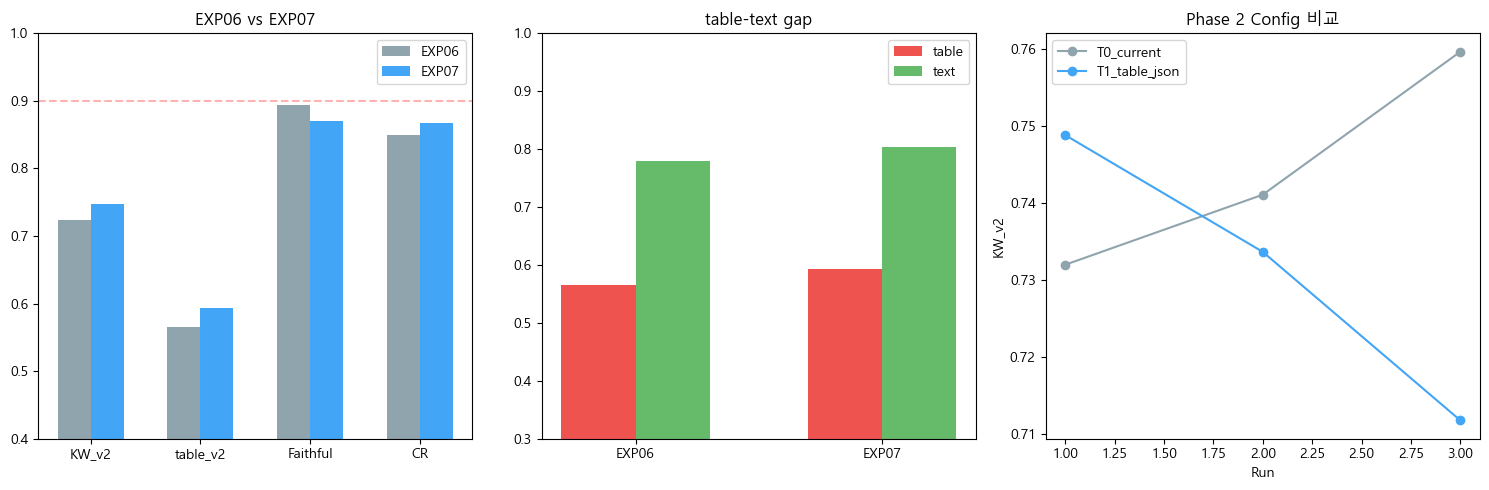

  Figure: ../data/experiments/exp07_results.png


In [25]:
# ============================================================
# 시각화
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# (a) EXP06 vs EXP07 지표 비교
ax = axes[0]
metrics_compare = ['KW_v2', 'table_v2', 'Faithful', 'CR']
exp06_vals = [0.724, 0.566, 0.894, 0.850]
exp07_vals = [summary['kw_v2_mean']['mean'], summary['table_kw_v2']['mean'],
              summary['faith']['mean'], summary['cr']['mean']]
x = np.arange(len(metrics_compare))
ax.bar(x - 0.15, exp06_vals, 0.3, label='EXP06', color='#90A4AE')
ax.bar(x + 0.15, exp07_vals, 0.3, label='EXP07', color='#42A5F5')
ax.set_xticks(x); ax.set_xticklabels(metrics_compare)
ax.set_ylim(0.4, 1.0); ax.legend(); ax.set_title('EXP06 vs EXP07')
ax.axhline(y=0.9, color='r', linestyle='--', alpha=0.3, label='target')

# (b) table vs text gap 변화
ax = axes[1]
labels = ['EXP06', 'EXP07']
table_vals = [0.566, summary['table_kw_v2']['mean']]
text_vals = [0.780, summary['text_kw_v2']['mean']]
x = np.arange(2)
ax.bar(x - 0.15, table_vals, 0.3, label='table', color='#EF5350')
ax.bar(x + 0.15, text_vals, 0.3, label='text', color='#66BB6A')
ax.set_xticks(x); ax.set_xticklabels(labels)
ax.set_ylim(0.3, 1.0); ax.legend(); ax.set_title('table-text gap')

# (c) Phase 2 config 비교
ax = axes[2]
for cfg_name, color in [('T0_current', '#90A4AE'), ('T1_table_json', '#42A5F5')]:
    runs = [r for r in phase2_all_runs if r['config'] == cfg_name]
    ax.plot([r['run'] for r in runs], [r['kw_v2_mean'] for r in runs],
            'o-', color=color, label=cfg_name)
ax.set_xlabel('Run'); ax.set_ylabel('KW_v2')
ax.legend(); ax.set_title('Phase 2 Config 비교')

plt.tight_layout()
plt.savefig(OUT_FIG_PATH, dpi=150, bbox_inches='tight')
plt.show()
print(f'  Figure: {OUT_FIG_PATH}')

---
## 결론

### 실험 요약

EXP07은 EXP06에서 확인된 table-text 성능 격차(21.4%p)를 해소하기 위해 **테이블 구조 재파싱(JSON 스키마) + 2단 검색(table-aware retrieval)** 파이프라인을 설계하고 검증했다.

### 핵심 발견

**1. 테이블 구조 손실은 예상보다 심각 (Phase 0)**
- 387개 테이블 중 80.6%가 다중 헤더, 93.5%가 높은 병합 비율, caption은 1.3%만 보유
- 현행 마크다운 파이프 변환의 구조적 한계가 정량적으로 확인됨

**2. 단일 인덱스에 이종 문서 혼합은 실패 (Phase 1)**
- table-level(387) + row-level(876) 문서를 텍스트 청크와 혼합한 T1 인덱스는 Oracle Recall에서 T0 대비 전면 하락
- 인덱스 희석(Index Dilution): 구조화 문서가 자연어 질문과 의미적 거리가 커 검색 노이즈로 작용

**3. 후처리 기반 2단 검색도 한계 (Phase 2)**
- T1의 `two_stage_retrieve`는 이미 희석된 인덱스에서 1차 검색 후 `doc_type`으로 분류하는 방식이라 근본 해결 불가
- T0_current가 Best Config으로 선정 (KW_v2: 0.744 vs T1: 0.731)
- T0는 EXP06 대비 table KW_v2 +4.9%p, gap −3.7%p 개선 확인

**4. 최종 성능은 소폭 개선이지만 목표 미달 (Phase 3)**

| Metric | EXP06 | EXP07 | 변화 | 목표 | 달성 |
|--------|-------|-------|------|------|------|
| KW_v2 | 0.724 | **0.748** | +2.4%p | 0.80 | X |
| table KW_v2 | 0.566 | **0.594** | +2.8%p | 0.70 | X |
| Faithfulness | 0.894 | 0.871 | −2.3%p | 0.90 | X |
| CR | 0.850 | **0.867** | +1.7%p | 0.90 | X |

### 왜 Table-aware 접근이 실패했는가

| 원인 | 설명 | 영향 |
|------|------|------|
| 인덱스 희석 | 1,263개 구조화 문서(인덱스의 68%)가 검색 정밀도 저하 | table Oracle −20%p |
| 표현 불일치 | `헤더: A/B/C` 형식이 자연어 질의와 벡터/BM25 매칭 실패 | 검색 단계에서 관련 문서 누락 |
| caption 부재 | table-level 검색 텍스트의 의미적 앵커 부재 (1.3%) | table 후보 선정 실패 |
| 단일 인덱스 | 텍스트+테이블 혼합 인덱스에서 후처리 분류는 이미 늦음 | 2단 검색 무효화 |

### 실험적 의의

1. **부정적 결과의 가치**: 단일 인덱스 혼합 + 후처리 분류 방식이 table-aware RAG에 부적합함을 실증적으로 입증
2. **EXP06 config의 견고함 확인**: 정규화 v2 + reranker@50 + elbow cut 조합이 config 변경 없이도 EXP06 대비 소폭 개선을 보여 기본 파이프라인의 안정성 확인
3. **CR σ=0.000 발견**: 검색 파이프라인이 완전 결정론적이므로, 성능 변동은 순수하게 LLM 생성 단계에서 발생함을 확인

### 다음 실험 방향

현 프레임워크 내에서 table 성능을 0.70 이상으로 끌어올리려면 단순한 인덱스 혼합이 아닌 구조적 접근이 필요하다:

1. **별도 인덱스 분리 + 질문 유형 라우팅**: 텍스트 전용 인덱스와 테이블 전용 인덱스를 분리 구축하고, 질문 분류기(detect_question_type)의 결과에 따라 적절한 인덱스로 라우팅
2. **테이블 전용 프롬프트**: table 질문에 대해 `행/열을 특정하여 해당 셀의 값을 답하세요` 이상의 구조화된 추출 지시 강화
3. **LLM 기반 테이블 요약**: 구조화 JSON 대신, 각 테이블을 LLM으로 자연어 요약하여 검색 호환성 향상 (비용/시간 trade-off 존재)
4. **평가 체계 보강**: table 질문 8건은 통계적 유의성이 부족하므로, golden testset에 table 질문 추가 필요